In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import cross_val_score

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Create dummy variables

In [ ]:
df = pd.read_csv('model.csv', index_col=0)

In [ ]:
df.head()

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df.columns.values

In [ ]:
ram = pd.get_dummies(df['mem_type'])

In [ ]:
disk = pd.get_dummies(df['storage_type'])

In [ ]:
graph = pd.get_dummies(df['graphics'])

In [ ]:
case = pd.get_dummies(df['form'])

In [ ]:
br = pd.get_dummies(df['brand'])

In [ ]:
df.drop(labels=['mem_type', 'storage_type', 'graphics', 'form', 'brand'], inplace=True, axis=1)

In [ ]:
categoricals = pd.concat([ram, disk, graph, case, br], sort=True, axis=1)

In [ ]:
df = df.join(categoricals)

In [ ]:
df.columns = df.columns.str.lower()

In [ ]:
df_viz = df[['price', 'proc_cores', 'proc_speed', 'mem_cap', 'num_usb', 'storage_cap']]

In [30]:
df = pd.read_csv('df_final.csv', index_col = 0)

# Filter for computers whose price is less than $800
df = df[df['price'] < 800]

## Modeling

I was torn between using a log-transformed response (price) and a square-root transformed response. I ended up going with the square-root transformed response because it resulted in a lower MSE. The log-transform made the response more normal, but the square root transform had better results. 

It was pretty clear from the start of the modeling phase that a second degree polynomial or higher leads to significant overfitting. The PolynomialFeatures part of my pipeline is vestigial, but I left it in to show my whole process.

In [9]:
y = df['price']

In [10]:
X = df.iloc[:, 1:]

In [11]:
def tts(df, d=1):
    # Simple single train test split OLS linear regression
    y = df['price']
    X = df.iloc[:, 1:]
    
    X_train, X_test, y_train, y_test = train_test_split(X, np.log(y))

    mod = LinearRegression()
    
    pipe = make_pipeline(PolynomialFeatures(d, interaction_only=True), StandardScaler(), mod)

    fit = pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    print(f'R^2: {fit.score(X_test, y_test)}')
    print(f'MSE: {mean_squared_error(y_pred, y_test)}')

In [69]:
def cross_val_log(df, degree, supress_outputs=False):
    # Cross validated, log-transformed response variable OLS linear regression
    X = df.iloc[:, 1:]
    y = df['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, np.log(y))
    
    reg = LinearRegression()

    pipe = make_pipeline(PolynomialFeatures(degree, interaction_only=True), StandardScaler(), reg)
    
    fit = pipe.fit(X_train, y_train)

    scores = cross_val_score(pipe, X_train, y_train, cv=10, scoring='r2')
    mse_scores = cross_val_score(pipe, X_train, np.exp(y_train), cv=10, scoring='neg_mean_squared_error')

    
    train_pred = pipe.predict(X_train)
    
    train_mse = -np.mean(mse_scores)
    
    y_pred = pipe.predict(X_test)
    
    # Untransform the response prediction and test
    y_pred = np.exp(y_pred)
    y_test = np.exp(y_test)
    
    test_mse = mean_squared_error(y_pred, y_test)
    
    if not supress_outputs:
        print(f'Cross validated training R^2: {np.mean(scores)}')
        print(f'Cross validated training MSE: {train_mse}')
        print(f'Test MSE: {test_mse}')
        print(f'Test score: {fit.score(X_test, np.log(y_test))}')
    
    return train_mse, test_mse, y_pred, y_test

In [66]:
def cross_val_sqrt(df, degree, supress_outputs=False):
    # Cross validated, square-root-transformed response variable OLS linear regression
    X = df.iloc[:, 1:]
    y = df['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, np.sqrt(y))
    
    reg = LinearRegression()

    pipe = make_pipeline(PolynomialFeatures(degree, interaction_only=True), StandardScaler(), reg)
    
    fit = pipe.fit(X_train, y_train)

    scores = cross_val_score(pipe, X_train, y_train, cv=10, scoring='r2')
    mse_scores = cross_val_score(pipe, X_train, y_train**2, cv=10, scoring='neg_mean_squared_error')

    
    train_pred = pipe.predict(X_train)
    
    # Place negative in front of mean because of sk-learn quirk
    train_mse = -np.mean(mse_scores)
    
    y_pred = pipe.predict(X_test)
    
    # Un-transform response predictions and tests
    y_pred = y_pred**2
    y_test = y_test**2
    
    test_mse = mean_squared_error(y_pred, y_test)
    
    if not supress_outputs:
        print(f'Cross validated training R^2: {np.mean(scores)}')
        print(f'Cross validated training MSE: {train_mse}')
    
        print(f'Test MSE: {test_mse}')
        print(f'Test score: {fit.score(X_test, np.sqrt(y_test))}')
    
    return train_mse, test_mse, y_pred, y_test

In [153]:
tr_mse, te_mse, yp_log, yt_log = cross_val_log(df, degree=1)

Cross validated training R^2: 0.727159026035483
Cross validated training MSE: 4091.2535049578923
Test MSE: 4378.193306850769
Test score: 0.7786877807793937


In [173]:
tr_mse, te_mse, yps_sqrt, yts_sqrt = cross_val_sqrt(df, degree=1)

Cross validated training R^2: 0.7356642789720672
Cross validated training MSE: 3737.2187654285817
Test MSE: 3928.3875814412104
Test score: 0.7412141557659901


## Model finalization

In the real world, I would finalize the model by training my chosen model on *all* my data. I am including this function as an exercise. My presentation will focus on the train vs test of my best model.

In [ ]:
def finalize_model(df):
    X = df.iloc[:, 1:]
    y = df['price']
    
    y = np.log(y)
    
    reg = LinearRegression()
    
    pipe = make_pipeline(StandardScaler(), reg)
    
    fit = pipe.fit(X, y)
    
    return np.exp(fit.predict(X))

The following function does 50 train test splits, calculates the training and testing $R^2$ and MSE, and returns lists of the those $R^2$ and MSE. By taking the mean of these lists I can get an idea of how my training and testing sets differ. This was for my own sanity to see how my model does over a large range of splits. 

In [185]:
def train_vs_test(df):
    X = df.iloc[:, 1:]
    y = np.sqrt(df.iloc[:, 0])
    
    tr_r2 = []
    te_r2 = []
    
    tr_mse = []
    te_mse = []

    for _ in range(50):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        
        reg = LinearRegression()
        
        pipe = make_pipeline(StandardScaler(), reg)
        
        pipe.fit(X_train, y_train)
        
        y_pred_train = pipe.predict(X_train)
        
        y_pred_test = pipe.predict(X_test)
        
        train_r2 = pipe.score(X_train, y_train)
        train_mse = mean_squared_error(y_pred_train**2, y_train**2)
        
        test_r2 = pipe.score(X_test, y_test)
        test_mse = mean_squared_error(y_pred_test**2, y_test**2)
        
        if (train_mse > 20000) or (test_mse > 20000) or (train_r2 > 1) or (test_r2 > 1):
            continue

        tr_mse.append(train_mse)
        te_mse.append(test_mse)
        
        tr_r2.append(train_r2)
        te_r2.append(test_r2)
        
    return tr_mse, te_mse, tr_r2, te_r2

In [186]:
tr_mse, te_mse, tr_r2, te_r2 = train_vs_test(df)

In [187]:
np.mean(tr_r2)

0.7558061148939776

In [188]:
np.mean(te_r2)

0.7293906874903027

In [189]:
np.mean(tr_mse)

3688.0494124839497

In [190]:
np.mean(te_mse)

4200.156994161276

## Visualisations

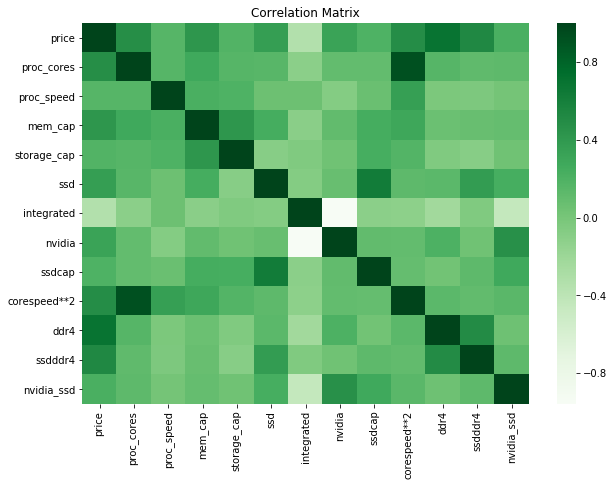

In [8]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(), cmap='Greens')
plt.title('Correlation Matrix');

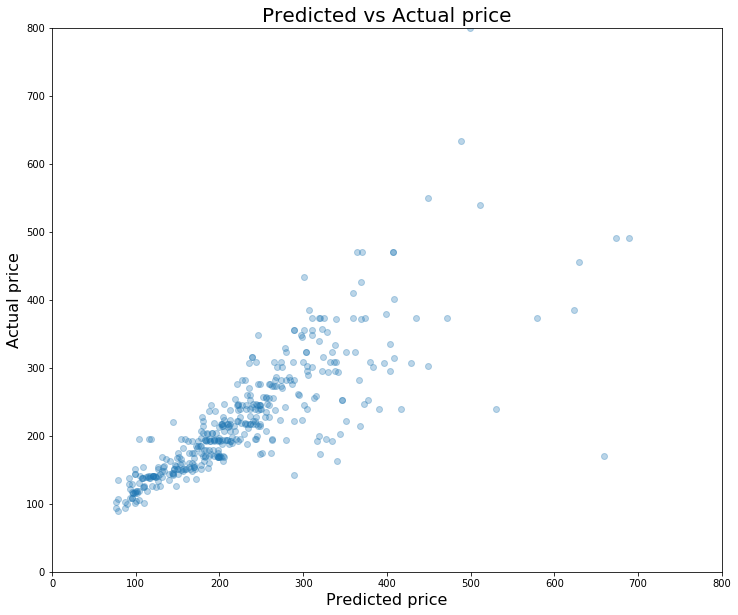

In [157]:
plt.figure(figsize=(12, 10))
plt.scatter(yt_log, yp_log, alpha=0.3)
plt.xlim([0, 800])
plt.ylim([0, 800])
plt.xlabel('Predicted price', size=16)
plt.ylabel('Actual price', size=16)
plt.title('Predicted vs Actual price', size=20);

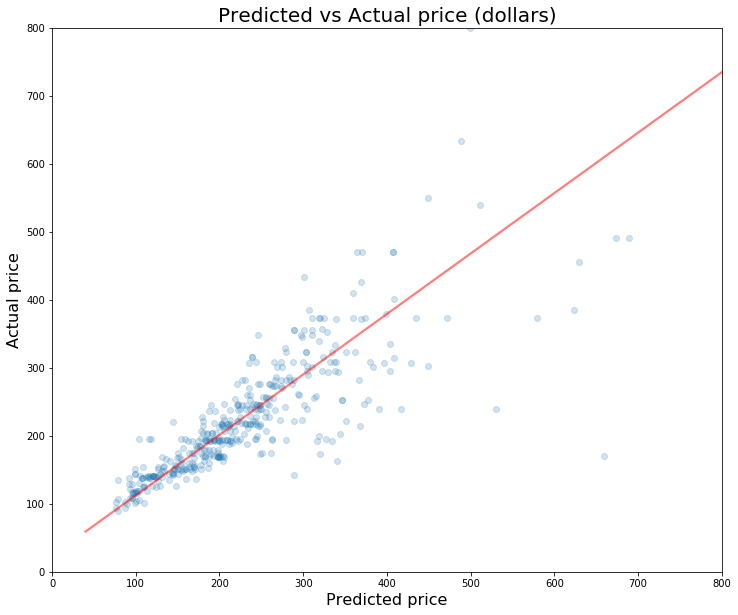

In [203]:
plt.figure(figsize=(12, 10))
sns.regplot(yt_log, yp_log, ci=0, scatter_kws={'alpha': 0.2}, line_kws={'color': 'r', 'alpha': 0.5})
plt.xlim([0, 800])
plt.ylim([0, 800])
plt.xlabel('Predicted price', size=16)
plt.ylabel('Actual price', size=16)
plt.title('Predicted vs Actual price (dollars)', size=20)
plt.savefig('pred-actual.png');

In [159]:
res_log = yt_log - yp_log

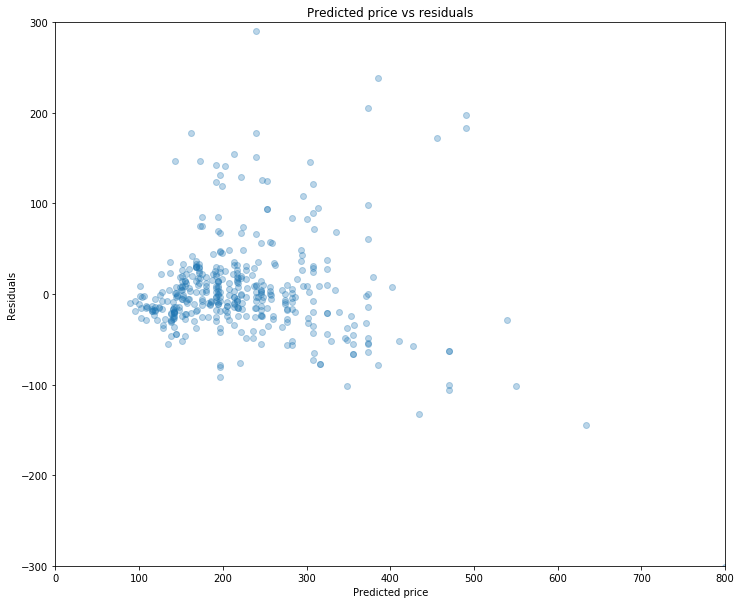

In [181]:
plt.figure(figsize=(12, 10))
plt.scatter(yp_log, res_log, alpha=0.3)
plt.xlabel('Predicted price')
plt.ylabel('Residuals')
plt.ylim([-300, 300])
plt.xlim([0, 800])
plt.title('Predicted price vs residuals');

In [162]:
from scipy import stats

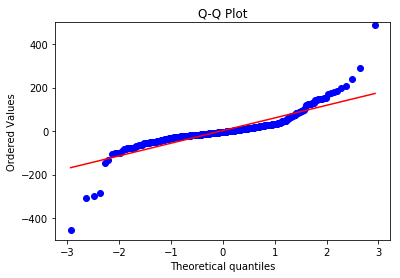

In [163]:
stats.probplot(res_log, dist='norm', plot=plt)
plt.ylim([-500, 500])
plt.title('Q-Q Plot');

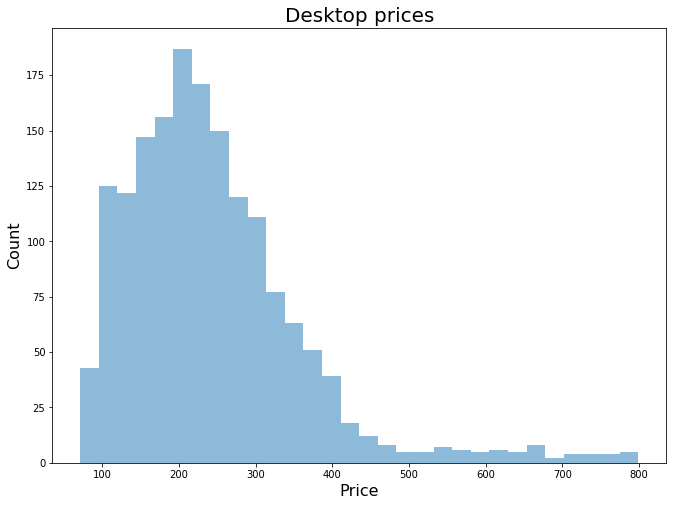

In [222]:
plt.figure(figsize=(11, 8))
plt.hist(df['price'], alpha=0.5, bins=30)
plt.xlabel('Price', size=16)
plt.ylabel('Count', size=16)
plt.title('Desktop prices', size=20)
plt.savefig('no-trans-hist.png');

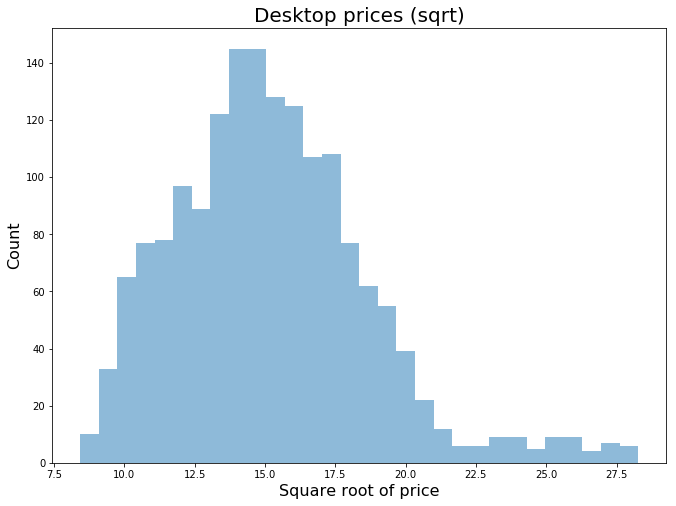

In [223]:
plt.figure(figsize=(11, 8))
plt.hist(np.sqrt(df['price']), alpha=0.5, bins=30)
plt.xlabel('Square root of price', size=16)
plt.ylabel('Count', size=16)
plt.title('Desktop prices (sqrt)', size=20)
plt.savefig('trans-hist.png');

In [191]:
tr_mse, te_mse, tr_r2, te_r2 = train_vs_test(df)

In [195]:
np.mean(tr_mse)

3781.3273766807733

In [196]:
np.mean(te_mse)

3882.2740756798385

In [197]:
np.mean(tr_r2)

0.7520579144782741

In [198]:
np.mean(te_r2)

0.7433209791159847

In [227]:
df.columns.values

array(['price', 'proc_cores', 'proc_speed', 'mem_cap', 'storage_cap',
       'ssd', 'integrated', 'nvidia', 'ssdcap', 'corespeed**2', 'ddr4',
       'ssdddr4', 'nvidia_ssd'], dtype=object)

In [211]:
df[(df['price'] > 540) & (df['price'] < 560)]

,price,proc_cores,proc_speed,mem_cap,storage_cap,ssd,integrated,nvidia,ssdcap,corespeed**2,ddr4,ssdddr4,nvidia_ssd
19,549,6.0,3.1,8.0,1024.0,0,1,0,0.0,345.96,1,0,0
69,549,2.0,3.1,4.0,500.0,0,1,0,0.0,38.44,1,0,0
364,549,4.0,3.4,8.0,500.0,0,1,0,0.0,184.96,1,0,0
441,559,6.0,3.4,16.0,2048.0,1,0,1,2048.0,416.16,0,0,1
493,548,4.0,3.2,8.0,2048.0,0,1,0,0.0,163.84,0,0,0
662,548,2.0,2.0,8.0,320.0,0,1,0,0.0,16.00,0,0,0
903,548,6.0,3.4,8.0,2048.0,0,1,0,0.0,416.16,0,0,0
1145,541,2.0,2.4,8.0,1024.0,0,0,1,0.0,23.04,0,0,0


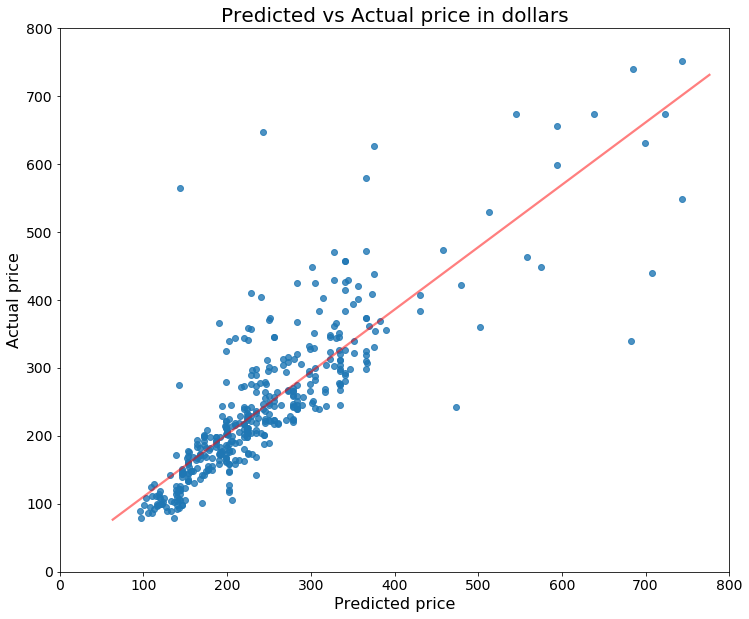

In [231]:
plt.figure(figsize=(12, 10))
sns.regplot(yps_sqrt, yts_sqrt, ci=0, line_kws={'color': 'r', 'alpha': 0.5})
plt.xlim([0, 800])
plt.ylim([0, 800])
plt.xlabel('Predicted price', size=16)
plt.ylabel('Actual price', size=16)
plt.title('Predicted vs Actual price in dollars', size=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('pred_actual_log.png');

In [178]:
res_sqrt = yts_sqrt - yps_sqrt

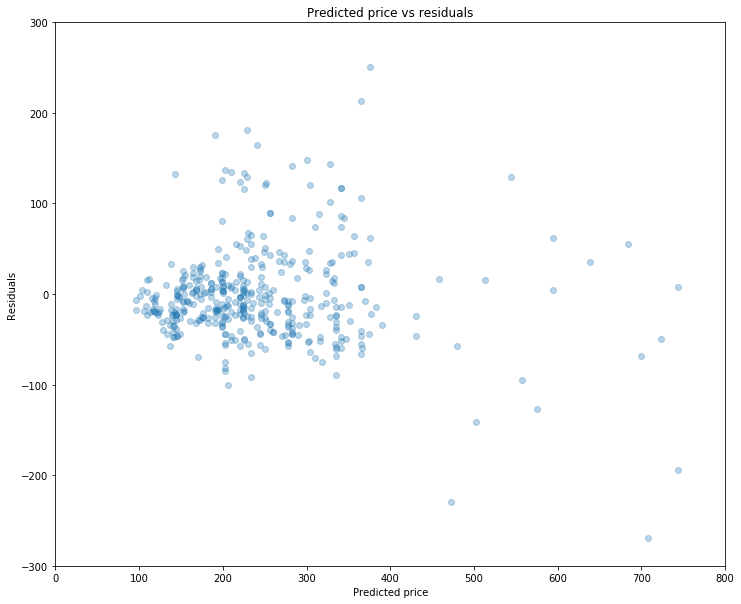

In [224]:
plt.figure(figsize=(12, 10))
plt.scatter(yps_sqrt, res_sqrt, alpha=0.3)
plt.xlabel('Predicted price')
plt.ylabel('Residuals')
plt.ylim([-300, 300])
plt.xlim([0, 800])
plt.title('Predicted price vs residuals')
plt.savefig('res-plot.png');

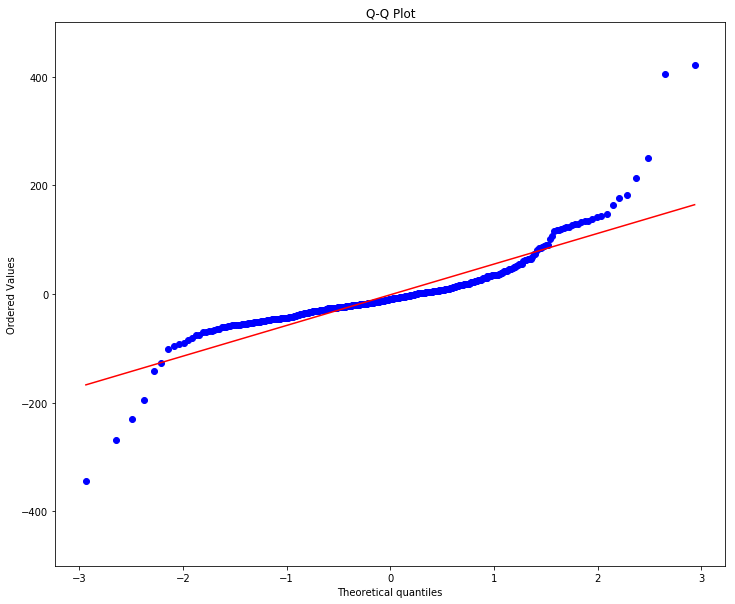

In [226]:
plt.figure(figsize=(12, 10))
stats.probplot(res_sqrt, dist='norm', plot=plt)
plt.ylim([-500, 500])
plt.title('Q-Q Plot')
plt.savefig('qq.png');

## Regularization

Regularization did not improve my model in any noticeable way, so I decided to go with a plain linear regression. Below is my code for regularization.

In [140]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [143]:
def regularization(df, degree, model=RidgeCV):
    #fig, axes = plt.subplots(2, 1, figsize=(7, 10))
    
    X = df.iloc[:, 1:]
    y = df['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, np.log(y), test_size=0.3)

    mse_train = []
    mse_test = []

    r2_train = []
    r2_test = []

    alphas = [1e-14, 1e-6, 1e-2, .01, 1, 10, 100, 1000]

    scaled_mod = make_pipeline(PolynomialFeatures(degree, interaction_only=True), StandardScaler(),
                               model(alphas=alphas, cv=10))
    scaled_mod.fit(X_train, y_train)

    mse_train = mean_squared_error(y_train, scaled_mod.predict(X_train))
    mse_test = mean_squared_error(y_test, scaled_mod.predict(X_test))

    r2_train = scaled_mod.score(X_train, y_train)
    r2_test = scaled_mod.score(X_test, y_test)
    
    print(f'Training MSE: {mse_train}')
    print(f'Testing MSE: {mse_test}')
    
    print(f'Training R^2: {r2_train}')
    print(f'Testing R^2: {r2_test}')
        
#     axes[0].semilogx(alphas, mse_train,label='train',c='r')
#     axes[0].semilogx(alphas, mse_test,label='test',c='b')
#     axes[0].legend()
#     axes[0].set_xlabel('Alpha')
#     axes[0].set_ylabel('MSE')
#     axes[0].set_ylim([0, 12000])
    
#     axes[1].semilogx(alphas,r2_train,label='train',c='r')
#     axes[1].semilogx(alphas,r2_test,label='test',c='b')
#     axes[1].set_ylim(0,1)
#     axes[1].legend()
#     axes[1].set_xlabel('Alpha')
#     axes[1].set_ylabel('Rˆ2');

In [144]:
regularization(df, degree=1, model=RidgeCV)

Training MSE: 0.05160105669710916
Testing MSE: 0.041131762206933875
Training R^2: 0.7414438616048336
Testing R^2: 0.7850851930268881


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.107246e-18
  overwrite_a=True).T
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.939012e-18
  overwrite_a=True).T
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.014862e-18
  overwrite_a=True).T
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.133995e-18
  overwrite_a=True).T
/anaconda3/lib/python3.6

In [145]:
def regularizationCV(df, model=RidgeCV):
    fig, axes = plt.subplots(2, 1, figsize=(7, 10))
    
    X = df.iloc[:, 1:]
    y = df['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    alphas = [1e-14, 1e-6, 1e-2, .01, 1, 100, 1000]

    
    
    mse_train = []
    mse_test = []
    
    r2_train = []
    r2_test = []
    
    for d in range(1, 4):
        scaled_mod = make_pipeline(PolynomialFeatures(d, interaction_only=True), StandardScaler(),
                                   model(alphas=alphas, cv=10))
        scaled_mod.fit(X_train, y_train)

        mse_train.append(mean_squared_error(y_train, scaled_mod.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, scaled_mod.predict(X_test)))

        r2_train.append(scaled_mod.score(X_train, y_train))
        r2_test.append(scaled_mod.score(X_test, y_test))
        
    axes[0].plot(range(1, 4), mse_train, label='train',c='r')
    axes[0].plot(range(1, 4), mse_test, label='test',c='b')
    axes[0].legend()
    axes[0].set_xlabel('Polynomial Degree')
    axes[0].set_ylabel('MSE')
    axes[0].set_ylim([0, 12000])
    
    axes[1].plot(range(1, 4), r2_train, label='train',c='r')
    axes[1].plot(range(1, 4), r2_test, label='test',c='b')
    axes[1].set_ylim(0,1)
    axes[1].legend()
    axes[1].set_xlabel('Polynomial Degree')
    axes[1].set_ylabel('Rˆ2');

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

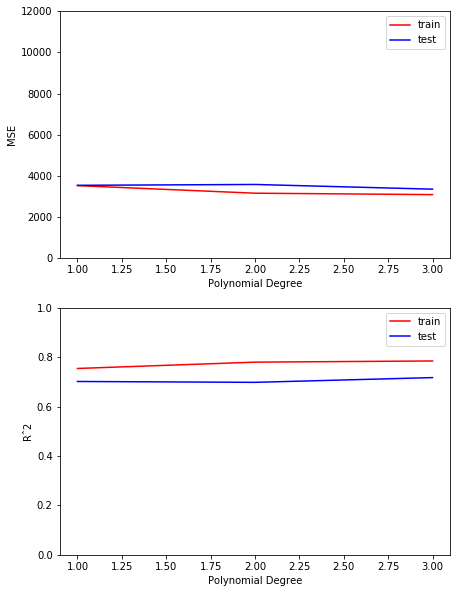

In [146]:
regularizationCV(df, model=LassoCV)

## Recursive feature elimination

This was an attempt for me to remove features that were not contributing to my model. RFECV (Recursive feature elimination cross validation) did not do much to help my model -- it wanted to keep all my features. I ended up not using this in my final product.

Below is my code to test feature elimination.

In [ ]:
from sklearn.feature_selection import RFECV 

def feature_reduction(X, y, deg=1):
    # Get best features of model using RFECV and make a new prediction using best features
    reg = LinearRegression() 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    reg.fit(X_train, y_train)
    
    mse_train = mean_squared_error(y_train, reg.predict(X_train))
    mse_test = mean_squared_error(y_test, reg.predict(X_test))
    
    r2_train = reg.score(X_train, y_train)
    r2_test = reg.score(X_test, y_test)
    
    # Check out MSE and R2 of train/test before we do feature reduction
    print('BEFORE FEATURE REDUCTION')
    print(f'Training MSE: {mse_train}\nTesting MSE: {mse_test}\nTraining R2: {r2_train}\nTesting R2: {r2_test}\n')

    # Make RFECV model and fit it
    rfecv = RFECV(estimator=reg, step=1, cv=10, scoring='r2')
    rfecv.fit(X_train, y_train)
    
    
    # Grab only the "best" Xs
    X_new = rfecv.transform(X)
    
    print(f'Reduced features shape: {X_new.shape}\n')
    
    # train test split using our new set of X's
    Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_new, y, test_size=0.3)
    
    pipe = make_pipeline(PolynomialFeatures(deg, interaction_only=True), StandardScaler(), LinearRegression())
    pipe.fit(Xn_train, yn_train)
    
    msen_train = mean_squared_error(yn_train, pipe.predict(Xn_train))
    msen_test = mean_squared_error(yn_test, pipe.predict(Xn_test))
    
    r2n_train = pipe.score(Xn_train, yn_train)
    r2n_test = pipe.score(Xn_test, yn_test)
    
    print('AFTER FEATURE REDUCTION')
    print(f'Training MSE: {msen_train}\nTesting MSE: {msen_test}\nTraining R2: {r2n_train}\nTesting R2: {r2n_test}')
    
    
    sns.regplot(pipe.predict(Xn_test), yn_test, ci=95, line_kws={'color': 'r'}, scatter_kws={'alpha': 0.4})
    plt.legend(('Line of best fit', 'Data'))
    plt.xlim([0, 1500])
    plt.ylim([0, 1500])
    plt.ylabel('Actual price')
    plt.xlabel('Predicted price');
    

In [232]:
feature_reduction(X, y, deg=1)

NameError: name 'feature_reduction' is not defined